# Libraries, parameters and functions

In [1]:
from glob2 import glob
import os
from sklearn.model_selection import train_test_split
import datetime
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow_addons as tfa

c:\users\virgi\appdata\local\programs\python\python37\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:43: UserWarning: You are currently using a nightly version of TensorFlow (2.10.0-dev20220427). 
TensorFlow Addons offers no support for the nightly versions of TensorFlow. Some things might work, some other might not. 
If you encounter a bug, do not file an issue on GitHub.
  UserWarning,


In [2]:
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(images=img, size=(img_height, img_width))
    return img

def process_path(x, y):
    img = tf.io.read_file(x)
    img = decode_img(img)
    return img , y

def process_path_sex(x, y, s):
    img = tf.io.read_file(x)
    img = decode_img(img)
    return (img,s) , y

def process_path_sex_height(x, y, s, h):
    img = tf.io.read_file(x)
    img = decode_img(img)
    return (img,s,h) , y

In [3]:
img_height = 240#480
img_width = 424#848
batch_size = 16
seed = 42
epochs = 50
name = 'xception'

metrics = ['mae', 'mse', 'mape', tfa.metrics.r_square.RSquare(dtype=tf.float32, y_shape=(1,), name='r2')]
metrics_name = ['MAE', 'MSE', 'MAPE', 'R2']

# Prepare dataset

In [4]:
x_files = glob('images\\*.png')
y_files = [float(file.split('_')[2]) for file in x_files]
s_files = [1 if (file.split('_')[1])=='Men' else 0 for file in x_files]
h_files = [float(file.split('_')[3]) for file in x_files]

X_train, X_val, y_train, y_val = train_test_split(x_files, y_files, test_size=0.30, random_state=seed)
s_train, s_val, _, _ = train_test_split(s_files, y_files, test_size=0.30, random_state=seed)
h_train, h_val, _, _ = train_test_split(h_files, y_files, test_size=0.30, random_state=seed)

In [5]:
files_train = tf.data.Dataset.from_tensor_slices((X_train, y_train))
files_val = tf.data.Dataset.from_tensor_slices((X_val, y_val))

train_ds = files_train.map(process_path).batch(batch_size)
val_ds = files_val.map(process_path).batch(batch_size)

In [6]:
files_train = tf.data.Dataset.from_tensor_slices((X_train, y_train, s_train))
files_val = tf.data.Dataset.from_tensor_slices((X_val, y_val, s_val))

train_ds_sex = files_train.map(process_path_sex).batch(batch_size)
val_ds_sex = files_val.map(process_path_sex).batch(batch_size)

In [7]:
files_train = tf.data.Dataset.from_tensor_slices((X_train, y_train, h_train))
files_val = tf.data.Dataset.from_tensor_slices((X_val, y_val, h_val))

train_ds_height = files_train.map(process_path_sex).batch(batch_size)
val_ds_height = files_val.map(process_path_sex).batch(batch_size)

In [8]:
files_train = tf.data.Dataset.from_tensor_slices((X_train, y_train, [h-1 for h in h_train]))
files_val = tf.data.Dataset.from_tensor_slices((X_val, y_val, [h-1 for h in h_val]))

train_ds_height_norm = files_train.map(process_path_sex).batch(batch_size)
val_ds_height_norm = files_val.map(process_path_sex).batch(batch_size)

In [9]:
files_train = tf.data.Dataset.from_tensor_slices((X_train, y_train, s_train, h_train))
files_val = tf.data.Dataset.from_tensor_slices((X_val, y_val, s_val, h_val))

train_ds_sex_height = files_train.map(process_path_sex_height).batch(batch_size)
val_ds_sex_height = files_val.map(process_path_sex_height).batch(batch_size)

In [10]:
files_train = tf.data.Dataset.from_tensor_slices((X_train, y_train, s_train, [h-1 for h in h_train]))
files_val = tf.data.Dataset.from_tensor_slices((X_val, y_val, s_val, [h-1 for h in h_val]))

train_ds_sex_height_norm = files_train.map(process_path_sex_height).batch(batch_size)
val_ds_sex_height_norm = files_val.map(process_path_sex_height).batch(batch_size)

# Regression Model

In [11]:
models = {
    'model' : {
        'train': train_ds,
        'val' : val_ds,
        'inputs' : 1
    },
    'model_with_sex' : {
        'train': train_ds_height,
        'val' : val_ds_height,
        'inputs': 2
    },
    'model_with_height' : {
        'train': train_ds_height,
        'val' : val_ds_height,
        'inputs': 2
    },
    'model_with_height_norm' : {
        'train': train_ds_height_norm,
        'val' : val_ds_height_norm,
        'inputs': 2
    },
    'model_with_sex_height':{
        'train': train_ds_sex_height,
        'val' : val_ds_sex_height,
        'inputs': 3
    },
    'model_with_sex_height_norm':{
        'train': train_ds_sex_height_norm,
        'val' : val_ds_sex_height_norm,
        'inputs': 3
    }
}

In [12]:
for f_name in models:
    print(f_name)
    
    base_model = keras.applications.Xception(weights='imagenet', input_shape=(img_height, img_width, 3), include_top=False)
    base_model.trainable = False

    inputs = keras.Input(shape=(img_height, img_width, 3))
    x = base_model(inputs, training=False)
    x = keras.layers.GlobalAveragePooling2D()(x)
    
    if models[f_name]['inputs'] == 1:
        x = keras.layers.Dense(128, activation='relu')(x)
        outputs = keras.layers.Dense(1)(x)
        model = keras.Model(inputs, outputs)
    elif models[f_name]['inputs'] == 2:
        x = keras.Model(inputs=inputs, outputs=x)
        inputB = keras.Input(shape=(1,))
        combined = keras.layers.concatenate([x.output, inputB])
        outputs = keras.layers.Dense(128, activation='relu')(combined)
        outputs = keras.layers.Dense(1)(outputs)
        model = keras.Model(inputs=[x.input, inputB], outputs=outputs)
    else:
        x = keras.Model(inputs=inputs, outputs=x)
        inputB = keras.Input(shape=(1,))
        inputC = keras.Input(shape=(1,))
        combined = keras.layers.concatenate([x.output, inputB, inputC])
        outputs = keras.layers.Dense(128, activation='relu')(combined)
        outputs = keras.layers.Dense(1)(outputs)
        model = keras.Model(inputs=[x.input, inputB, inputC], outputs=outputs)
 
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001), loss='mae', metrics=metrics)
    h = model.fit(models[f_name]['train'], epochs=epochs, validation_data=models[f_name]['val'])

    model.save('results/'+name+'_'+f_name+'.h5')
    df_historic = pd.DataFrame(h.history)
    df_historic.to_csv('results/'+name+'_'+f_name+'.csv')
    
    print('-------------------------------------------------------------')

model
Epoch 1/50
89/89 [==============================] - 25s 199ms/step - loss: 15.8498 - mae: 15.8498 - mse: 296.3815 - mape: 69.1572 - r2: -12.2290 - val_loss: 8.4890 - val_mae: 8.4890 - val_mse: 104.9153 - val_mape: 34.4348 - val_r2: -3.5048
Epoch 2/50
89/89 [==============================] - 16s 182ms/step - loss: 6.5390 - mae: 6.5390 - mse: 59.2110 - mape: 28.7345 - r2: -1.6429 - val_loss: 5.7686 - val_mae: 5.7686 - val_mse: 43.2102 - val_mape: 27.5784 - val_r2: -0.8553
Epoch 3/50
89/89 [==============================] - 17s 193ms/step - loss: 5.2153 - mae: 5.2153 - mse: 35.5479 - mape: 25.0670 - r2: -0.5867 - val_loss: 4.8845 - val_mae: 4.8845 - val_mse: 30.8788 - val_mape: 23.8723 - val_r2: -0.3259
Epoch 4/50
89/89 [==============================] - 17s 196ms/step - loss: 4.2916 - mae: 4.2916 - mse: 24.6261 - mape: 21.0009 - r2: -0.0992 - val_loss: 3.8963 - val_mae: 3.8963 - val_mse: 20.5802 - val_mape: 19.3880 - val_r2: 0.1163
Epoch 5/50
89/89 [==============================] 

89/89 [==============================] - 16s 183ms/step - loss: 0.7284 - mae: 0.7284 - mse: 1.5131 - mape: 3.3250 - r2: 0.9325 - val_loss: 0.8288 - val_mae: 0.8288 - val_mse: 1.8426 - val_mape: 3.8816 - val_r2: 0.9209
Epoch 37/50
89/89 [==============================] - 16s 180ms/step - loss: 0.7128 - mae: 0.7128 - mse: 1.4678 - mape: 3.2540 - r2: 0.9345 - val_loss: 0.8166 - val_mae: 0.8166 - val_mse: 1.7957 - val_mape: 3.8317 - val_r2: 0.9229
Epoch 38/50
89/89 [==============================] - 16s 181ms/step - loss: 0.7035 - mae: 0.7035 - mse: 1.4254 - mape: 3.2129 - r2: 0.9364 - val_loss: 0.8051 - val_mae: 0.8051 - val_mse: 1.7550 - val_mape: 3.7866 - val_r2: 0.9246
Epoch 39/50
89/89 [==============================] - 16s 181ms/step - loss: 0.6975 - mae: 0.6975 - mse: 1.3927 - mape: 3.1884 - r2: 0.9378 - val_loss: 0.7952 - val_mae: 0.7952 - val_mse: 1.7153 - val_mape: 3.7481 - val_r2: 0.9264
Epoch 40/50
89/89 [==============================] - 16s 180ms/step - loss: 0.6819 - mae: 0.

89/89 [==============================] - 17s 187ms/step - loss: 0.8621 - mae: 0.8621 - mse: 1.9640 - mape: 3.9479 - r2: 0.9123 - val_loss: 0.9107 - val_mae: 0.9107 - val_mse: 2.2046 - val_mape: 4.2664 - val_r2: 0.9053
Epoch 22/50
89/89 [==============================] - 17s 187ms/step - loss: 0.8354 - mae: 0.8354 - mse: 1.8822 - mape: 3.8224 - r2: 0.9160 - val_loss: 0.8929 - val_mae: 0.8929 - val_mse: 2.1452 - val_mape: 4.1549 - val_r2: 0.9079
Epoch 23/50
89/89 [==============================] - 16s 185ms/step - loss: 0.8175 - mae: 0.8175 - mse: 1.8117 - mape: 3.7397 - r2: 0.9191 - val_loss: 0.8787 - val_mae: 0.8787 - val_mse: 2.0782 - val_mape: 4.0881 - val_r2: 0.9108
Epoch 24/50
89/89 [==============================] - 17s 185ms/step - loss: 0.7953 - mae: 0.7953 - mse: 1.7325 - mape: 3.6383 - r2: 0.9227 - val_loss: 0.8581 - val_mae: 0.8581 - val_mse: 1.9854 - val_mape: 4.0059 - val_r2: 0.9148
Epoch 25/50
89/89 [==============================] - 17s 186ms/step - loss: 0.7724 - mae: 0.

89/89 [==============================] - 17s 190ms/step - loss: 1.9870 - mae: 1.9870 - mse: 7.9664 - mape: 9.7719 - r2: 0.6444 - val_loss: 1.8591 - val_mae: 1.8591 - val_mse: 7.4374 - val_mape: 9.4404 - val_r2: 0.6807
Epoch 7/50
89/89 [==============================] - 17s 190ms/step - loss: 1.7676 - mae: 1.7676 - mse: 6.4629 - mape: 8.6507 - r2: 0.7115 - val_loss: 1.6838 - val_mae: 1.6838 - val_mse: 6.1598 - val_mape: 8.4685 - val_r2: 0.7355
Epoch 8/50
89/89 [==============================] - 17s 190ms/step - loss: 1.6031 - mae: 1.6031 - mse: 5.3916 - mape: 7.7909 - r2: 0.7593 - val_loss: 1.5250 - val_mae: 1.5250 - val_mse: 5.1848 - val_mape: 7.5813 - val_r2: 0.7774
Epoch 9/50
89/89 [==============================] - 17s 189ms/step - loss: 1.4647 - mae: 1.4647 - mse: 4.6166 - mape: 7.0746 - r2: 0.7939 - val_loss: 1.4154 - val_mae: 1.4154 - val_mse: 4.5181 - val_mape: 6.9800 - val_r2: 0.8060
Epoch 10/50
89/89 [==============================] - 17s 190ms/step - loss: 1.3506 - mae: 1.350

Epoch 42/50
89/89 [==============================] - 17s 190ms/step - loss: 0.5762 - mae: 0.5762 - mse: 1.0038 - mape: 2.6422 - r2: 0.9552 - val_loss: 0.6892 - val_mae: 0.6892 - val_mse: 1.3019 - val_mape: 3.2670 - val_r2: 0.9441
Epoch 43/50
89/89 [==============================] - 17s 190ms/step - loss: 0.5695 - mae: 0.5695 - mse: 0.9851 - mape: 2.6165 - r2: 0.9560 - val_loss: 0.6850 - val_mae: 0.6850 - val_mse: 1.2757 - val_mape: 3.2465 - val_r2: 0.9452
Epoch 44/50
89/89 [==============================] - 17s 191ms/step - loss: 0.5581 - mae: 0.5581 - mse: 0.9515 - mape: 2.5636 - r2: 0.9575 - val_loss: 0.6735 - val_mae: 0.6735 - val_mse: 1.2492 - val_mape: 3.2158 - val_r2: 0.9464
Epoch 45/50
89/89 [==============================] - 17s 190ms/step - loss: 0.5535 - mae: 0.5535 - mse: 0.9307 - mape: 2.5459 - r2: 0.9585 - val_loss: 0.6653 - val_mae: 0.6653 - val_mse: 1.2177 - val_mape: 3.1707 - val_r2: 0.9477
Epoch 46/50
89/89 [==============================] - 17s 190ms/step - loss: 0.54

89/89 [==============================] - 16s 182ms/step - loss: 0.7818 - mae: 0.7818 - mse: 1.6881 - mape: 3.5785 - r2: 0.9247 - val_loss: 0.8586 - val_mae: 0.8586 - val_mse: 1.9793 - val_mape: 4.0030 - val_r2: 0.9150
Epoch 28/50
89/89 [==============================] - 16s 181ms/step - loss: 0.7680 - mae: 0.7680 - mse: 1.6266 - mape: 3.5166 - r2: 0.9274 - val_loss: 0.8397 - val_mae: 0.8397 - val_mse: 1.9123 - val_mape: 3.9323 - val_r2: 0.9179
Epoch 29/50
89/89 [==============================] - 16s 182ms/step - loss: 0.7491 - mae: 0.7491 - mse: 1.5637 - mape: 3.4330 - r2: 0.9302 - val_loss: 0.8281 - val_mae: 0.8281 - val_mse: 1.8539 - val_mape: 3.8781 - val_r2: 0.9204
Epoch 30/50
89/89 [==============================] - 16s 182ms/step - loss: 0.7351 - mae: 0.7351 - mse: 1.5114 - mape: 3.3667 - r2: 0.9325 - val_loss: 0.8168 - val_mae: 0.8168 - val_mse: 1.8118 - val_mape: 3.8253 - val_r2: 0.9222
Epoch 31/50
89/89 [==============================] - 16s 182ms/step - loss: 0.7221 - mae: 0.

89/89 [==============================] - 17s 188ms/step - loss: 1.1702 - mae: 1.1702 - mse: 3.2359 - mape: 5.4716 - r2: 0.8556 - val_loss: 1.1358 - val_mae: 1.1358 - val_mse: 3.1823 - val_mape: 5.3355 - val_r2: 0.8634
Epoch 13/50
89/89 [==============================] - 17s 187ms/step - loss: 1.1130 - mae: 1.1130 - mse: 2.9731 - mape: 5.1789 - r2: 0.8673 - val_loss: 1.0948 - val_mae: 1.0948 - val_mse: 2.9916 - val_mape: 5.1110 - val_r2: 0.8715
Epoch 14/50
89/89 [==============================] - 17s 187ms/step - loss: 1.0693 - mae: 1.0693 - mse: 2.7728 - mape: 4.9626 - r2: 0.8762 - val_loss: 1.0582 - val_mae: 1.0582 - val_mse: 2.8214 - val_mape: 4.9302 - val_r2: 0.8789
Epoch 15/50
89/89 [==============================] - 17s 186ms/step - loss: 1.0272 - mae: 1.0272 - mse: 2.5950 - mape: 4.7646 - r2: 0.8842 - val_loss: 1.0438 - val_mae: 1.0438 - val_mse: 2.7455 - val_mape: 4.8377 - val_r2: 0.8821
Epoch 16/50
89/89 [==============================] - 17s 186ms/step - loss: 0.9998 - mae: 0.

Epoch 48/50
89/89 [==============================] - 16s 185ms/step - loss: 0.4988 - mae: 0.4988 - mse: 0.7318 - mape: 2.3162 - r2: 0.9673 - val_loss: 0.6075 - val_mae: 0.6075 - val_mse: 0.9924 - val_mape: 2.9310 - val_r2: 0.9574
Epoch 49/50
89/89 [==============================] - 17s 186ms/step - loss: 0.4877 - mae: 0.4877 - mse: 0.7105 - mape: 2.2669 - r2: 0.9683 - val_loss: 0.6037 - val_mae: 0.6037 - val_mse: 0.9812 - val_mape: 2.9195 - val_r2: 0.9579
Epoch 50/50
89/89 [==============================] - 17s 187ms/step - loss: 0.4817 - mae: 0.4817 - mse: 0.6966 - mape: 2.2388 - r2: 0.9689 - val_loss: 0.6010 - val_mae: 0.6010 - val_mse: 0.9610 - val_mape: 2.9108 - val_r2: 0.9587
-------------------------------------------------------------
model_with_sex_height_norm
Epoch 1/50
89/89 [==============================] - 20s 200ms/step - loss: 12.7889 - mae: 12.7889 - mse: 215.2693 - mape: 55.2462 - r2: -5.6587 - val_loss: 6.5862 - val_mae: 6.5862 - val_mse: 57.8717 - val_mape: 29.0979 -

89/89 [==============================] - 17s 191ms/step - loss: 0.6208 - mae: 0.6208 - mse: 1.0860 - mape: 2.8636 - r2: 0.9515 - val_loss: 0.7171 - val_mae: 0.7171 - val_mse: 1.3327 - val_mape: 3.3837 - val_r2: 0.9428
Epoch 34/50
89/89 [==============================] - 17s 190ms/step - loss: 0.6148 - mae: 0.6148 - mse: 1.0533 - mape: 2.8390 - r2: 0.9530 - val_loss: 0.7062 - val_mae: 0.7062 - val_mse: 1.2968 - val_mape: 3.3336 - val_r2: 0.9443
Epoch 35/50
89/89 [==============================] - 17s 191ms/step - loss: 0.6073 - mae: 0.6073 - mse: 1.0201 - mape: 2.8034 - r2: 0.9545 - val_loss: 0.6979 - val_mae: 0.6979 - val_mse: 1.2629 - val_mape: 3.2975 - val_r2: 0.9458
Epoch 36/50
89/89 [==============================] - 17s 191ms/step - loss: 0.5989 - mae: 0.5989 - mse: 0.9972 - mape: 2.7702 - r2: 0.9555 - val_loss: 0.6827 - val_mae: 0.6827 - val_mse: 1.2292 - val_mape: 3.2405 - val_r2: 0.9472
Epoch 37/50
89/89 [==============================] - 17s 192ms/step - loss: 0.5791 - mae: 0.

# Results

model


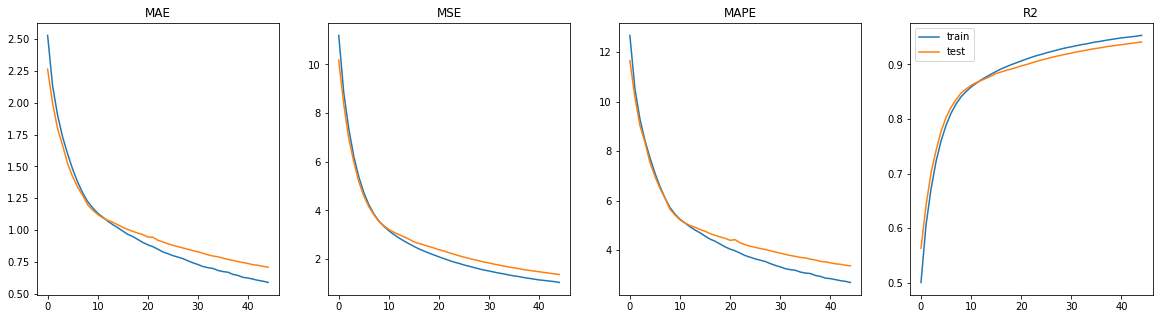

model_with_sex


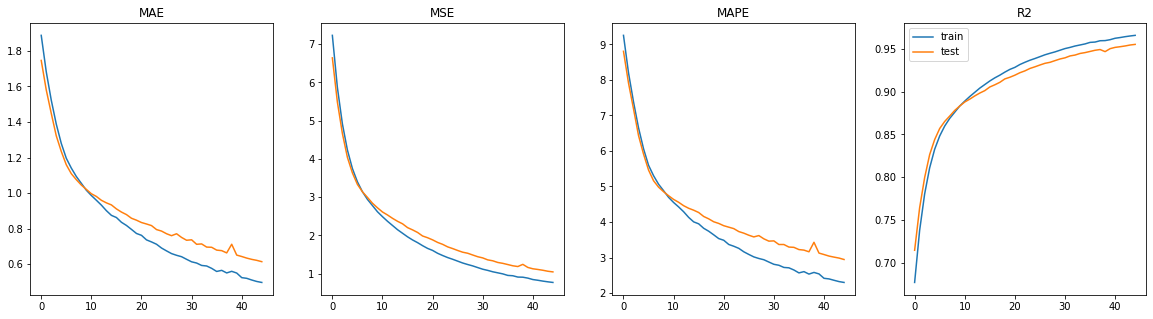

model_with_height


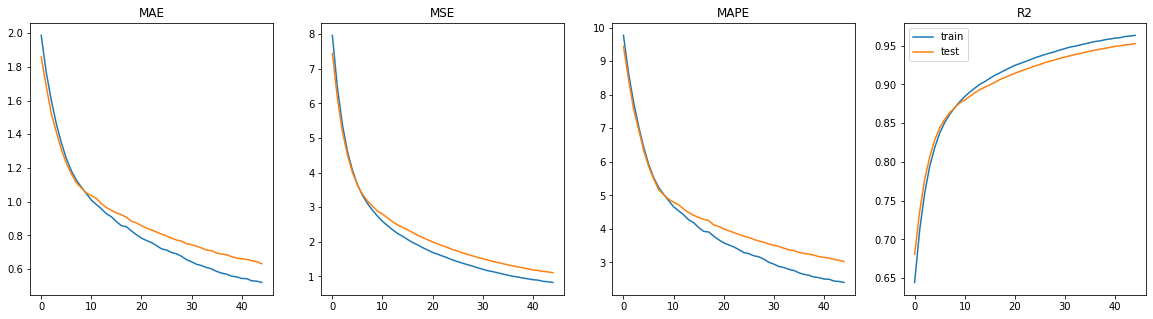

model_with_height_norm


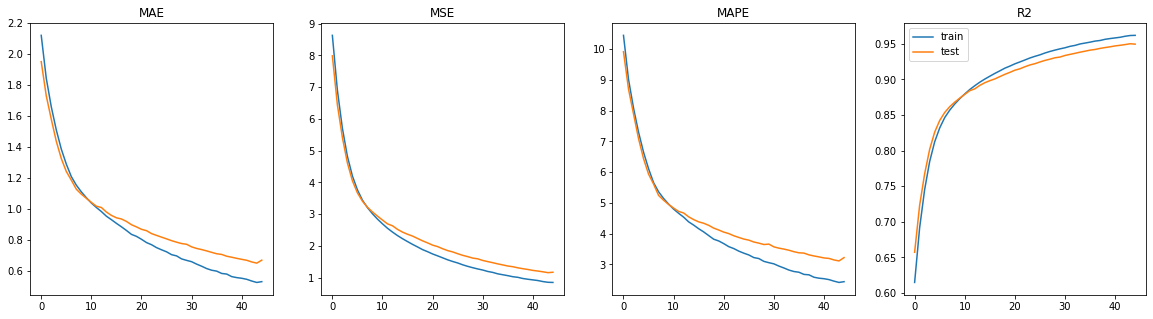

model_with_sex_height


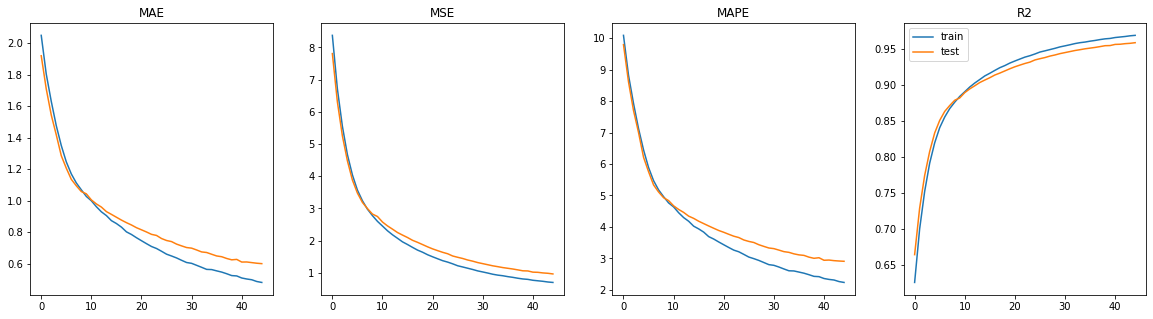

model_with_sex_height_norm


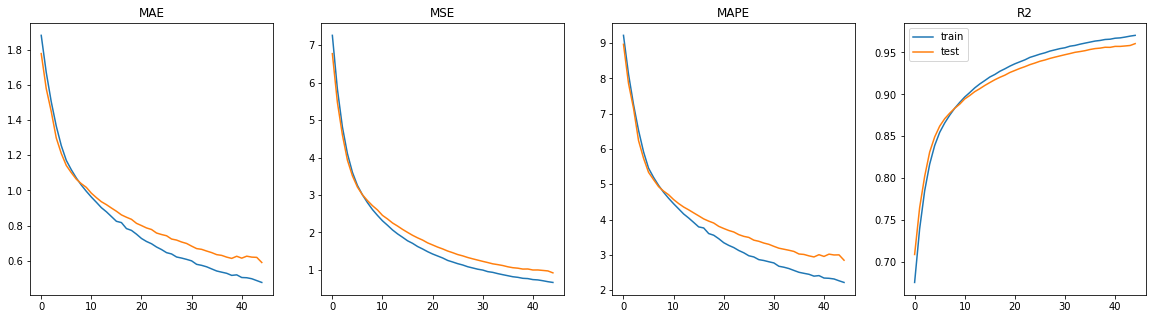

In [13]:
columns = ['model']+[name.lower() for name in metrics_name]+['val_'+name.lower() for name in metrics_name]
results = pd.DataFrame(columns=columns)

for f_name in models:
    print(f_name)
    df_historic = pd.read_csv('results/'+name+'_'+f_name+'.csv')
    #df_historic.rename(columns = {'R2':'r2', 'val_R2':'val_r2'}, inplace = True)
    fig, ax = plt.subplots(1, len(metrics), figsize=(20, 5))

    info={}
    info['model'] = f_name
    for metric, i in zip(metrics_name, range(len(metrics))):
        ax[i].plot(df_historic[metric.lower()].values[5:], label='train')
        ax[i].plot(df_historic['val_'+metric.lower()].values[5:], label='test')
        ax[i].set_title(metric)
        info[metric.lower()] = df_historic.iloc[-1][metric.lower()]
        info['val_'+metric.lower()] = df_historic.iloc[-1]['val_'+metric.lower()]
    results = results.append(info, ignore_index=True)

    plt.legend()
    plt.show()

In [14]:
results_t = results.set_index('model').transpose()
pd.options.display.float_format = "{:,.4f}".format

In [15]:
results_t

model,model,model_with_sex,model_with_height,model_with_height_norm,model_with_sex_height,model_with_sex_height_norm
mae,0.5877,0.4965,0.5207,0.5293,0.4817,0.4760
mse,1.0430,0.7708,0.8257,0.8509,0.6966,0.6664
mape,2.6963,2.2979,2.4020,2.4405,2.2388,2.2174
r2,0.9534,0.9656,0.9631,0.9620,0.9689,0.9703
val_mae,0.7077,0.6135,0.6319,0.6681,0.6010,0.5896
val_mse,1.3692,1.0468,1.1064,1.1721,0.9610,0.9223
val_mape,3.3696,2.9437,3.0224,3.2224,2.9108,2.8471
val_r2,0.9412,0.9551,0.9525,0.9497,0.9587,0.9604


In [16]:
with open('results/'+name+'_results.tex', 'w') as tf:
     tf.write(results_t.to_latex())